# Project: Dense Prediction: Monocular Depth Estimation and Semantic Segmentation

<img src='https://i.imgur.com/I2rSgxd.png' width=200> <img src='https://i.imgur.com/1oP2EIg.png' width=200>

# Part 1 : Monocular Depth Estimation

## Introduction

- In this part of the project, we are tasked to create a model that **estimates depth from a single input image**. The input is an RGB image and the output is a single channel dense depth map where each pixel is the estimated distance from the 'camera sensor' to an object in the scene in real world units (e.g. in meters). Depth from a single image is a fundemental vision task with many useful applications including scene understanding and reconstruction.

- We will develop a convolutional neural network (CNN) that formulates the problem as a regression of the depth map from a single RGB image. 

- In this section, we provide all the source code needed for loading and evaluating the model.  We will reuse the model in the next section

- The task in this section is to modify the code in order to:
    - Define a [UNet](https://arxiv.org/abs/1505.04597) model that takes an RGB image and outputs a single channel depth map.
    - Define an approprate loss function.
    - Tune the model to achieve an RMSE of **0.035** or less on the given validation set.


## Downloading data

In [1]:
# Part 1 Libraries
#!pip install tqdm datasets timm
from torchvision import transforms as T
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision.utils import make_grid
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import numpy as np
from tqdm.auto import tqdm
import gc
import os

import datasets

ds = datasets.load_dataset("shariqfarooq/cs323_densepred_depth")  # DO NOT change this
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'depth'],
        num_rows: 25356
    })
    test: Dataset({
        features: ['image', 'depth'],
        num_rows: 518
    })
})

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

image_transforms = T.Compose([
  #T.RandomHorizontalFlip(),
  #T.RandomRotation(15),
  T.ToTensor(),
  T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

depth_transforms = T.Compose([
    T.ToTensor()
])

def transform(batch):
  batch['image'] = ([image_transforms(im) for im in batch['image']])
  batch['depth'] = [depth_transforms(d)[:1] for d in batch['depth']]
  return batch

ds.set_transform(transform)


In [3]:
ds['train'][0]['image'].shape, ds['train'][0]['depth'].shape

(torch.Size([3, 256, 256]), torch.Size([1, 128, 128]))

### Sanity check 

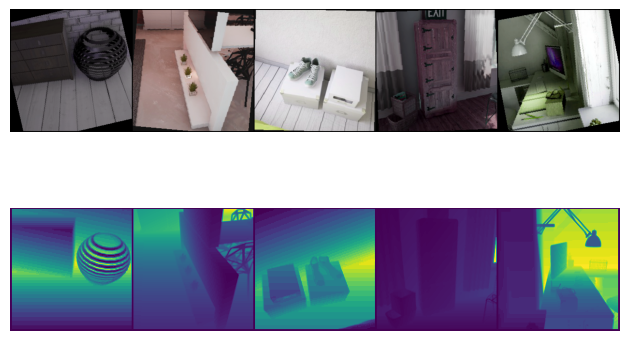

In [3]:
# Examine training data

def denorm_imagenet(x):
    mean, std = torch.tensor(IMAGENET_MEAN).to(x.device), torch.tensor(IMAGENET_STD).to(x.device)
    if x.ndim == 3:
        mean, std = mean[:, None, None], std[:, None, None]
    elif x.ndim == 4:
        mean, std = mean[None, :, None, None], std[None, :,  None, None]

    return x * std + mean


def show_example_data(dataset, split='train', num=5):
    im_stacked = []
    depth_stacked = []
    for i in range(num):
        sample = dataset[split][i]
        im_stacked.append(denorm_imagenet(sample['image']))
        depth_stacked.append(sample['depth'])
    
    im_stacked = make_grid(torch.stack(im_stacked), nrow=num)
    depth_stacked = make_grid(torch.stack(depth_stacked), nrow=num, normalize=True, scale_each=True)

    fig, ax = plt.subplots(2, 1)
    ax[0].imshow(im_stacked.permute(1, 2, 0))
    ax[1].imshow(depth_stacked[0])
    for a in ax:
        a.axis('off')
    
    plt.tight_layout()
    plt.show()

show_example_data(ds)

### Getting started with timm

[`timm`](https://timm.fast.ai/) is a popular deep-learning library created by [Ross Wightman](https://twitter.com/wightmanr) and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results. 

We will be using `timm` to load encoder backbones pretrained on ImageNet so we don't have to define encoder architectures (that you did in previous projects) or start training from scratch



In [4]:
# timm example for loading any encoder architecture

model = timm.create_model('resnet34') # load resnet34 architecture
x     = torch.randn(1, 3, 224, 224)  # create random input tensor
model(x).shape

torch.Size([1, 1000])

In [5]:
# You can also load a pretrained model
pretrained_resnet_34 = timm.create_model('resnet34', pretrained=True)

In [6]:
# List al available models
avail_pretrained_models = timm.list_models(pretrained=True)

print(f"Number of available pretrained models: {len(avail_pretrained_models)}")
print(f"First 5 models: {avail_pretrained_models[:5]}")

Number of available pretrained models: 1242
First 5 models: ['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k']


As you can see, we have vast variety of available pretrained models (750+)! In this project, you are free to choose any one of them

In [ ]:
# Searching through 750+ models can be a pain. timm provides glob filtering so we can filter the models by name
# Lets list all the models that have 'efficientnet' in their name
all_efficientnet_models = timm.list_models('*efficientnet*', pretrained=True)
#all_efficientnet_models

### Feature extraction with timm

In [7]:
BACKBONE = "resnet34"  # TODO: Change this to your desired backbone

In [8]:
# Let's tell timm that we only need features from various from various layers (and not final ImageNet class logits)
encoder = timm.create_model(BACKBONE, pretrained=True, features_only=True)

In [ ]:
print("Channel info:", encoder.feature_info.channels())
x = torch.rand(1, 3, 224, 224)
out = encoder(x)
assert type(out) is list
[o.shape for o in out]

#### Note that now we are able to get multi-scale features from our encoder. You will use this to build your Unet

## Model

In [3]:
# with skip connection
def double(in_ch, out_ch):
    double_conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return double_conv

class Unet(nn.Module):
    """
    TODO: Complete the docstring of the Unet class (description, parameters, returns, etc.)
    """

    def __init__(
            self,
            BACKBONE='resnet50',
            num_classes=1,
            final_activation = nn.Softmax(1), # # TODO: Change this to your desired final activation
            # TODO: Add any other relevant args you need
    ):
        super().__init__()
        # TODO: Complete the definition of the Unet class
        # Use timm to load the encoder backbone with imagenet pretrained weights
        # encoder **must** return a list of feature maps that will be used by the decoder
        self.encoder = create_model(
            BACKBONE,  
            pretrained=True,
            features_only=True
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(2048, 1024),

            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(1024, 512),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(512, 256),

            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(128, 64),

            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, num_classes, kernel_size=1),
            ),
        )
        
        self.dropout = nn.Dropout(0.2)
        self.final_activation = final_activation
    
    def forward(self, x: torch.Tensor):
        # TODO: Complete the forward function
        encoder_outs = self.encoder(x)
        #print(encoder_outs[0].shape); print(encoder_outs[4].shape)
        feature_maps = encoder_outs[::-1]
        
        # Decoder
        x = self.decoder[0](feature_maps[0])
        #print(x.shape)
        x = (torch.cat((x, feature_maps[1]), 1))
        #print(x.shape)
        x = self.decoder[1](x)
        #print(x.shape)

        x = self.decoder[2](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[2]), 1))
        #print(x.shape)
        x = self.decoder[3](x)
        #print(x.shape)

        x = self.decoder[4](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[3]), 1))
        #print(x.shape)
        x = self.decoder[5](x)
        #print(x.shape)

        x = self.decoder[6](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[4]), 1))
        #print(x.shape)
        x = self.decoder[7](x)
        #print(x.shape)

        x = self.decoder[8](x)
        #print(x.shape)

        #x = self.dropout(x)
        #x = self.final_activation(x)
        return x

In [4]:
BACKBONE = "resnet50"  # TODO: Change this to your desired backbone
model = Unet(BACKBONE, num_classes=1)

# Always perform a sanity check on the models you define
x = torch.randn(1, 3, 512, 512)
out = model(x)
print("Input shape", x.shape)
print("Output shape", out.shape)

# Move to GPUs. Using all GPUs available by default. You can change this.
#model = nn.DataParallel(model)
model = model.cuda()

Input shape torch.Size([1, 3, 512, 512])
Output shape torch.Size([1, 1, 256, 256])


## Loss Function

Define a loss function that is suitable for the depth estimation. Look up the latest papers, for example on [PapersWithCode leaderboards](https://paperswithcode.com/sota/monocular-depth-estimation-on-nyu-depth-v2).
Why will the current loss not work?

**Because it is not non-negative, while loss function should be non-negative function. Also, it lack of Scale Invariance and sensitivity.**

In [5]:
def loss_fn(pred_y, y):
    return torch.mean((y - pred_y)**2)
#loss_fn = nn.CrossEntropyLoss()

## Training + Evaluation

Tune the hyperparameters and the architecture to achieve the target RMSE

In [6]:
### Hyperparameters
# TODO: Change these to your desired hyperparameters

epochs = 50
batch_size = 32
learning_rate = 0.0001

workers = 6 # The number of parallel processes used to read data. Increase this if you have more cores.
train_loader = DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=workers)

/home/alsalemz/miniconda3/envs/dl323/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
run_id = f'model_n{epochs}_bs{batch_size}_lr{learning_rate}'; print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

# TODO: Experiment with different optimizers and learning rate schedulers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.98)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0

ITER_PER_EPOCH = len(train_loader)
TOTAL_STEPS = ITER_PER_EPOCH * epochs


metrics = RMSE()

@torch.no_grad()
def validate(model, valid_loader):
    model.eval()
    metrics.reset()
    for i, (sample) in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validating'):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        y_pred = model(x).detach().cpu().numpy()
        metrics.add_batch(y_pred, y)
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))


# One validation before we start training (good practice to catch errors early)
validate(model, test_loader)
pbar = tqdm(total=TOTAL_STEPS, desc='Training')
for epoch in range(epochs):
    model.train()
    N = len(train_loader)
    print(epoch)

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        # learning rate scheduler step.
        # TODO: location of this call might change depending on your choice of scheduler. 
        scheduler.step()

        pbar.update(1)
        # Report progress. Add any extra logging info here
        pbar.set_postfix({'epoch': f'{epoch+1}/{N}', 'loss': loss.item(), 'epoch%': "{0:.1f}%".format(100*(i+1)/N)})
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    validate(model, test_loader)
    

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

## Visual Test of the Trained Model

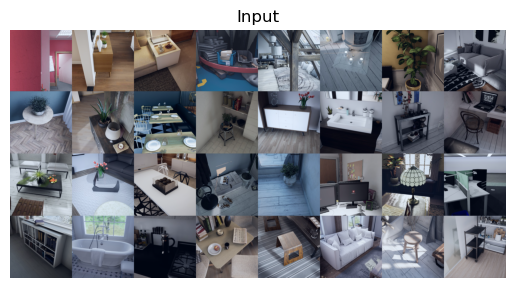

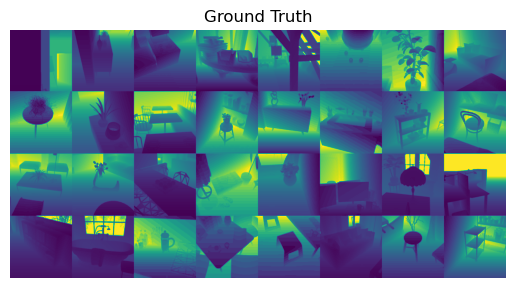

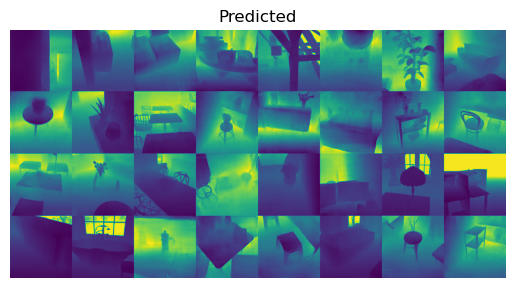

In [10]:
# Load model from disk
model.load_state_dict(torch.load(run_id + '.pkl'))
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(test_loader)
sample = next(sample)
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

# plt.figure(figsize=(20,20))
plt.imshow(make_grid(sample['image'], padding=0, normalize=True).permute((1, 2, 0)))
plt.axis('off')
plt.title("Input")
plt.show()

# plt.figure(figsize=(20,20))
plt.imshow(make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Ground Truth")
plt.show()

# plt.figure(figsize=(20,20))
plt.imshow(make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Predicted")
plt.show()

# Part 2 : Semantic Segmentation

In this part of the project, we will reuse the model we created in the previous part to perform Semantic Segmentation - instead of assigning a real number to each
pixel, we will assign it a class.

The tasks are as following:
- Implement data prepareation: encoding and decoding of segmentation maps
- Modify the UNet model that takes an RGB image and now outputs a _label map_ of _N_ classes
- Define an approprate loss function.
- Tune the model to achieve an mIOU of **0.45** or higher on the given validation set.
- Visualization

## Data Preparation

We are going to use the [PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/), which is a commonly used benchmark. In order to reduce the
computational requirements, we will be using [a variant](https://huggingface.co/datasets/shariqfarooq/cs323_densepred_seg256) that has a uniform and slightly lower resolution (256x256) than official. 

In [26]:
# Part 2 Libraries
# Lets load the dataset first
from datasets import load_dataset
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torch
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils import Metrics
from tqdm.auto import tqdm
import gc

ds_voc = load_dataset("shariqfarooq/cs323_densepred_seg256")  # DO NOT change this

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Examine training data

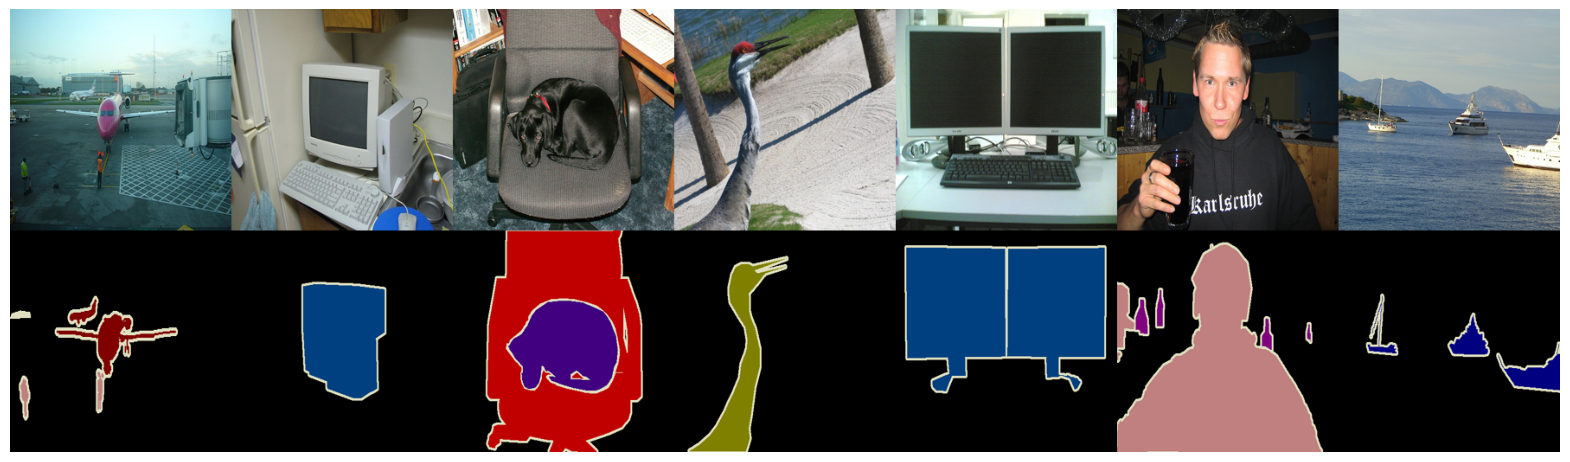

In [13]:
def make_pil_grid(images, nrow=8):
    grid = Image.new('RGB', (images[0].width*nrow, images[0].height*((len(images)-1)//nrow+1)))
    for i, im in enumerate(images):
        grid.paste(im, (i%nrow*images[0].width, i//nrow*images[0].height))
    return grid

def show_example_data(dataset, split='train', num=7, nrow=7):
    ims = [dataset[split][i]['image'] for i in range(num)]
    masks = [dataset[split][i]['mask'] for i in range(num)]
    im_grid = make_pil_grid(ims, nrow)
    mask_grid = make_pil_grid(masks, nrow)

    grid = make_pil_grid([im_grid, mask_grid], 1)
    plt.figure(figsize=(20,20))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

show_example_data(ds_voc)

### pascal/segmap

Now we have to implement the encoding and decoding of the data.

Make sure that the labels are in the range `0..N-1`, where
N is the number of classes - 21 in our case. We can have one special label for unknown regions.

We provide the map of RGB to label for convenience in `get_pascal_color_palette()`. The map should be read as this - if a pixel has color `[0, 0, 0]`, it has label 0. If the color is `[128, 0, 0]`, the label is 1 and so on.

We need to use the palette information to implement `encode_segmap` and `decode_segmap` functions

In [44]:
def get_pascal_color_palette():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],[0, 0, 128],[128, 0, 128],[0, 128, 128],
                       [128, 128, 128],[64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],[64, 0, 128],[192, 0, 128],
                       [64, 128, 128],[192, 128, 128],[0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128]])

def get_pascal_class_names():
    return ['Background','Aeroplane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable',
            'Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']

def encode_segmap(mask, unk_label=255):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray or PIL.Image.Image): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    # TODO: Complete this function
    mask = np.array(mask)
    M, N, c = mask.shape
    encode = np.zeros((M,N)).astype(int)
    for i, code in enumerate(get_pascal_color_palette()):
        #print(code)
        match = (mask == np.array(code).reshape(1, 1, 3)).all(axis=2)
        encode[match] = i
        
    encode[mask[:, :, 0] == unk_label] = unk_label
    
    return encode

def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask = mask.astype(int)
    mask[mask == unk_label] = 0
    # TODO: Complete this function

    palette = get_pascal_color_palette()
    #M, N = mask.shape
    #r = np.zeros((M,N)).astype(int)
    #g = np.zeros((M,N)).astype(int)
    #b = np.zeros((M,N)).astype(int)

    r = np.zeros_like(mask)
    g = np.zeros_like(mask)
    b = np.zeros_like(mask)
    
    for p in range(0, len(palette)):
        i = mask == p
        r[i] = palette[p, 0]
        g[i] = palette[p, 1]
        b[i] = palette[p, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [27]:
# TODO: Optionally add data augmentations to increase performance. 
# Note that any augmentation should act jointly on image and its mask label.  Look up `albumentations`.
im_transforms = T.Compose([
    #T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250]) ### comment, the range of RGB
])

def transform_voc(batch):
    batch['image'] = [im_transforms(i) for i in batch['image']]
    batch['mask'] = [torch.tensor(encode_segmap(m)) for m in batch['mask']]
    return batch

ds_voc.set_transform(transform_voc)

### Perform sanity tests as required

In [25]:
# TODO: Add sanity tests
for _, d in enumerate(ds_voc):
    leng = ds_voc[d].shape[0]
    for i in range(leng):
        data = ds_voc[d][i]
        images = data['image']
        masks = data['mask']
        for image, mask in zip(images, masks):
            assert torch.all((image >= 0.0) & (image <= 1.0)), "RGB values should be between 0 and 1"
            assert (torch.min(mask) >= 0) & (torch.max(mask) <= 21.0), "Label values should be between 0 and 21"
            assert torch.is_tensor(mask), "Mask should be a tensor"
            assert mask.dtype == torch.long, "Label tensor should have dtype torch.long"
print("sanity tests succeeded")

sanity tests succeeded


## Modifying Architecture and the loss
We will have to do some form of surgery on the network you constructed in Part 1.
We have to make sure we are initializing the weights with the depth model we trained above. And then doctor the model such that we attach a new _Segmentation Head_ as our final block.

1. The number of channels the last layer predicts must change to the number of classes in the dataset. The last activation may also change. 
2. The loss function must change to reflect the fact that we are now performing per-pixel classification.
3. We might get a CUDA assert error. This means that we have a label higher than the number of channels in the _logits_. This is very common with semantic segmentation, where we might want to label some region unkown as it's label might be under doubt - for example near the edges of objects. Look up how to ignore a certain label with a classification loss.
4. Take care of input, label and logit sizes. We want predictions to be 256x256 as well, so we may need an upsampling layer in the _Segmentation Head_

In [28]:
### Hyperparameters
# TODO: Change these to your desired hyperparameters
epochs = 50
batch_size = 32
learning_rate = 0.0001

workers = 4 # The number of parallel processes used to read data. Increase this if you have more cores.
train_loader = DataLoader(ds_voc['train'], batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(ds_voc['val'], batch_size=batch_size, num_workers=workers)

In [ ]:
# with skip connection
def double(in_ch, out_ch):
    double_conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return double_conv

class Unet(nn.Module):
    """
    TODO: Complete the docstring of the Unet class (description, parameters, returns, etc.)
    """

    def __init__(
            self,
            BACKBONE='resnet50',
            num_classes=1,
            final_activation = nn.Softmax(1), # # TODO: Change this to your desired final activation
            # TODO: Add any other relevant args you need
    ):
        super().__init__()
        # TODO: Complete the definition of the Unet class
        # Use timm to load the encoder backbone with imagenet pretrained weights
        # encoder **must** return a list of feature maps that will be used by the decoder
        self.encoder = create_model(
            BACKBONE,  
            pretrained=True,
            features_only=True
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(2048, 1024),

            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(1024, 512),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(512, 256),

            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            #nn.ReLU(inplace=True),
            double(128, 64),

            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, num_classes, kernel_size=1),
            ),
        )
        
        self.dropout = nn.Dropout(0.2)
        self.final_activation = final_activation
    
    def forward(self, x: torch.Tensor):
        # TODO: Complete the forward function
        encoder_outs = self.encoder(x)
        #print(encoder_outs[0].shape); print(encoder_outs[4].shape)
        feature_maps = encoder_outs[::-1]
        
        # Decoder
        x = self.decoder[0](feature_maps[0])
        #print(x.shape)
        x = (torch.cat((x, feature_maps[1]), 1))
        #print(x.shape)
        x = self.decoder[1](x)
        #print(x.shape)

        x = self.decoder[2](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[2]), 1))
        #print(x.shape)
        x = self.decoder[3](x)
        #print(x.shape)

        x = self.decoder[4](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[3]), 1))
        #print(x.shape)
        x = self.decoder[5](x)
        #print(x.shape)

        x = self.decoder[6](x)
        #print(x.shape)
        x = (torch.cat((x, feature_maps[4]), 1))
        #print(x.shape)
        x = self.decoder[7](x)
        #print(x.shape)

        x = self.decoder[8](x)
        #print(x.shape)

        #x = self.dropout(x)
        #x = self.final_activation(x)
        return x

In [29]:
BACKBONE = "resnet50" # TODO: Change this to your desired backbone

In [30]:
# Load the pretrained depth model
depth_pretrained_path = "model_n50_bs32_lr0.0001.pkl"  # TODO: Specify the path to your trained depth model
model = Unet(BACKBONE, num_classes=1)
#model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load(depth_pretrained_path))

<All keys matched successfully>

### Segmentation Head

In [31]:
class SegHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegHead, self).__init__()
        self.seg = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=1),
            )

    def forward(self, x):
        x = self.seg(x)
        return x

def change_classes(unet, target_classes=21):
    in_channels = unet.decoder[-1][0].in_channels
    seg_head = SegHead(in_channels, target_classes)    
    unet.decoder[-1] = seg_head
    
    return unet

# Change the number of classes to 22
model = change_classes(model, target_classes=21)
model = model.cuda()

In [35]:
#def loss_fn(pred_y, y):
    #TODO: Change this to your desired loss function. 
#    return torch.mean((y - pred_y)**2)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)

## Training and Evaluation
Tune the hyperparameters to get the maximum possible score on the PASCAL VOC challenge. 
And answer the following questions:
1. What is the relationship between the _size_ of the class and the IOU How would you quantify this relationship?
2. What is the relationship between the number of instances and the IOU? how many times a class exists in an image vs the IOU?
3. Which weights can you not transfer from the depth model?

**1. The relationship between the size of the class and the IoU is negative. Where the boundaries of smaller objects in the class are harder to predict. Quantifing this relationship can be done by using correlation coefficients or regression analysis.**

**2. The relationship can be considered as negative generally, where overlaping and occlusion make segmentation more challenging. We can check IoU scores for one class and see how they change with changing how many times a class exists in the image.**

**3. The output (last) layer, where it is specified for that depth task and we need to replace it. Generally whenever the layer is more specific or useful for depth estimation, it will be less useful in segmentation.**


In [33]:
# Always perform a sanity check on the models you define
x = torch.randn(1, 3, 512, 512).cuda()
out = model(x)
print("Input shape", x.shape)
print("Output shape", out.shape)

Input shape torch.Size([1, 3, 512, 512])
Output shape torch.Size([1, 21, 512, 512])


In [ ]:
run_id = f'seg_model_n{epochs}_bs{batch_size}_lr{learning_rate}'; print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

# TODO: Experiment with different optimizers and learning rate schedulers
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)

metrics = Metrics(len(get_pascal_class_names()), get_pascal_class_names())


ITER_PER_EPOCH = len(train_loader)
TOTAL_STEPS = ITER_PER_EPOCH * epochs

@torch.no_grad()
def validate(model, valid_loader):
    model.eval()
    metrics.reset()
    for i, (sample) in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validating'):
        x, y = sample['image'].float().cuda(), sample['mask'].numpy()
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
    print('\nValidation stats ', metrics.get_table())

validate(model, test_loader)
pbar = tqdm(total=TOTAL_STEPS, desc='Training')
for epoch in range(epochs):
    model.train()

    N = len(train_loader)

    for i, (sample) in enumerate(train_loader):
        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['mask'].long().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        scheduler.step() # TODO: location of this call might change depending on your choice of scheduler.
        pbar.update(1)
        pbar.set_postfix({'epoch': f"{epoch+1}/{epochs}", 'loss': loss.item(), 'epoch%': "{0:.1f}%".format(100*(i+1)/N)})

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    validate(model, test_loader)

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

## Visualization
Use the `decode_segmap` function to visualize images and their Ground Truth and Predicted segmentation maps. The images must be from the validation set.


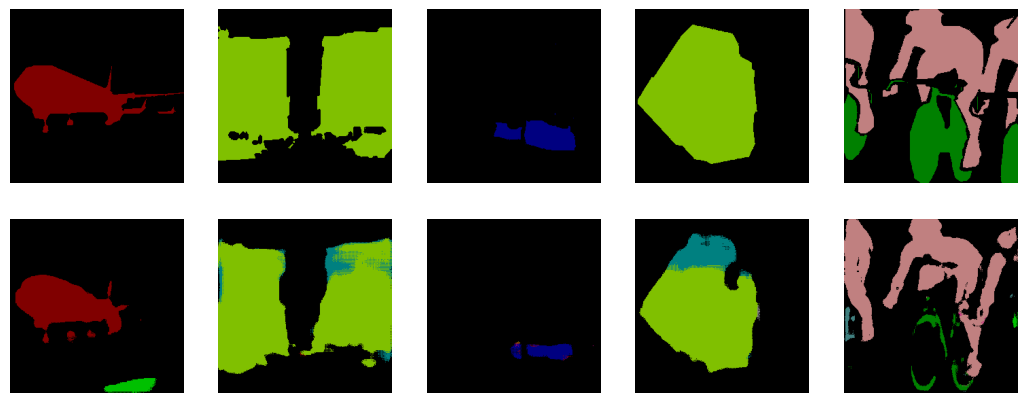

In [63]:
# TODO: Implement visualization
def visualize(model, dataset):
    num_samples = 5
    _, axes = plt.subplots(2, num_samples, figsize=(13, 5))
    
    for i in range(num_samples):
        mask = dataset['val'][i]["mask"].to(device)
        image = dataset["val"][i]["image"].unsqueeze(dim=0).to(device)
        
        model.eval()
        with torch.no_grad():
            res = model(image)
            res = torch.argmax(F.softmax(res.squeeze(), dim=0), dim=0).cpu().numpy()
            res = decode_segmap(res)

        axes[0, i].imshow(decode_segmap(mask.cpu().numpy()))
        axes[0, i].axis('off')
        
        axes[1, i].imshow(res)
        axes[1, i].axis('off')

    plt.show()

visualize(model, ds_voc)
